# <center> <img src="../../labs/img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
### <center> **Procesamiento de Datos Masivos** </center>
---
### <center> **Primavera 2025** </center>
---
**Primer Examen**

**Fecha**: 14 de Marzo del 2025

**Nombre del estudiante**:

**Professor**: Pablo Camarillo Ramirez

In [1]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SparkSQL-Exam-1-ANGEL-CORTES") \
    .master("spark://873bad4e62fe:7077") \
    .config("spark.ui.port","4040") \
    .getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/14 13:43:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### 1.Read the Data (10 points):
Load the employees.csv and departments.csv files into PySpark DataFrames.

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import *



departments_schema = StructType([
    StructField("department_id", IntegerType(), True),
    StructField("department_name", StringType(), True),
    StructField("location", StringType(), True)
])


employees_schema = StructType([
    StructField("employee_id", IntegerType(), True),
    StructField("employee_info", StringType(), True)
])


departments_df = spark.read \
    .schema(departments_schema) \
    .option("header", "true") \
    .csv("/home/jovyan/notebooks/data/departments.csv")


employees_df = spark.read \
    .schema(employees_schema) \
    .option("header", "true") \
    .csv("/home/jovyan/notebooks/data/employees.csv")


departments_df.printSchema()
departments_df.show(5, truncate=False)

employees_df.printSchema()
employees_df.show(5, truncate=False)

root
 |-- department_id: integer (nullable = true)
 |-- department_name: string (nullable = true)
 |-- location: string (nullable = true)



+-------------+----------------------+---------+
|department_id|department_name       |location |
+-------------+----------------------+---------+
|101          |Human Resources       |San Diego|
|102          |Finance and Accounting|New York |
|103          |Sales and Marketing   |Chicago  |
|104          |Data Engineering      |Zapopan  |
|105          |Data Science          |Seattle  |
+-------------+----------------------+---------+
only showing top 5 rows

root
 |-- employee_id: integer (nullable = true)
 |-- employee_info: string (nullable = true)

+-----------+-------------------------------------------------------------------------------------------+
|employee_id|employee_info                                                                              |
+-----------+-------------------------------------------------------------------------------------------+
|1          |{'name': 'Caitlyn', 'department_id': 103, 'salary': 115959.78, 'hire_date': '2002-06-10'}  |
|2          |{'

### 2. Extract the employee info from the JSON column (20 points):
Extract the following the columns: name (string), department_id (integer), salary (double), and hire_date (date) from the employee_info column

In [11]:
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType


employee_info_schema = StructType([
    StructField("name", StringType(), True),
    StructField("department_id", IntegerType(), True),
    StructField("salary", DoubleType(), True),
    StructField("hire_date", DateType(), True)
])


employees_parsed_df = employees_df.withColumn(
    "parsed_info", 
    from_json(col("employee_info"), employee_info_schema)
)


employees_extracted_df = employees_parsed_df.select(
    col("employee_id"),
    col("parsed_info.name"),
    col("parsed_info.department_id").alias("department_id"),
    col("parsed_info.salary").alias("salary"),
    col("parsed_info.hire_date")
  
)


employees_extracted_df.printSchema()
employees_extracted_df.show(10, truncate=False)


root
 |-- employee_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- salary: double (nullable = true)
 |-- hire_date: date (nullable = true)

+-----------+---------+-------------+---------+----------+
|employee_id|name     |department_id|salary   |hire_date |
+-----------+---------+-------------+---------+----------+
|1          |Caitlyn  |103          |115959.78|2002-06-10|
|2          |Rachel   |104          |100820.16|2009-07-01|
|3          |Carrie   |105          |114421.44|1998-12-10|
|4          |Renee    |104          |54688.13 |1995-03-17|
|5          |Gabriella|109          |106267.03|1995-02-09|
|6          |Kristen  |101          |88237.54 |2010-11-15|
|7          |Jonathan |102          |39323.42 |2012-06-30|
|8          |Michelle |101          |64262.85 |2005-10-30|
|9          |Michelle |105          |103521.88|1991-07-10|
|10         |Lisa     |110          |55435.93 |2016-03-25|
+-----------+---------+-

### 3. Join Operations (10 points):
Join the employees DataFrame with the departments DataFrame on department_id to enrich the employee data with department details.

In [13]:
enriched_employees_df = employees_extracted_df.join(
    departments_df,
    employees_extracted_df["department_id"] == departments_df["department_id"],
    "left"
)


enriched_employees_df = enriched_employees_df.drop(departments_df["department_id"])


print("DataFrame enriquecido con información de departamentos:")
enriched_employees_df.printSchema()
enriched_employees_df.show(10, truncate=False)


DataFrame enriquecido con información de departamentos:
root
 |-- employee_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- salary: double (nullable = true)
 |-- hire_date: date (nullable = true)
 |-- department_name: string (nullable = true)
 |-- location: string (nullable = true)

+-----------+---------+-------------+---------+----------+-------------------------------------------+-------------+
|employee_id|name     |department_id|salary   |hire_date |department_name                            |location     |
+-----------+---------+-------------+---------+----------+-------------------------------------------+-------------+
|1          |Caitlyn  |103          |115959.78|2002-06-10|Sales and Marketing                        |Chicago      |
|2          |Rachel   |104          |100820.16|2009-07-01|Data Engineering                           |Zapopan      |
|3          |Carrie   |105          |114421.44|1998-12-10|Data 

### 4.Transformations (Using when()) (10 points):
Add a new column salary_category to the enriched employee DataFrame:

If salary is greater than or equal to 55000, set salary_category to "High".

Otherwise, set salary_category to "Low".

In [16]:
from pyspark.sql.functions import when, lit

enriched_employees_df = enriched_employees_df.withColumn(
    "salary_category",
    when(col("salary") >= 55000, "High")
    .otherwise("Low")
)

# Mostrar el DataFrame con la nueva columna
print("DataFrame con columna salary_category:")
enriched_employees_df.printSchema()
enriched_employees_df.show(10, truncate=False)


DataFrame con columna salary_category:
root
 |-- employee_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- salary: double (nullable = true)
 |-- hire_date: date (nullable = true)
 |-- department_name: string (nullable = true)
 |-- location: string (nullable = true)
 |-- salary_category: string (nullable = false)

+-----------+---------+-------------+---------+----------+-------------------------------------------+-------------+---------------+
|employee_id|name     |department_id|salary   |hire_date |department_name                            |location     |salary_category|
+-----------+---------+-------------+---------+----------+-------------------------------------------+-------------+---------------+
|1          |Caitlyn  |103          |115959.78|2002-06-10|Sales and Marketing                        |Chicago      |High           |
|2          |Rachel   |104          |100820.16|2009-07-01|Data Engineering           

### 5.Filter and Group (20 points):
Create two new data frames: one that filters employees with a “High” salary and another that filters employees with a “Low” salary.

Calculate the average salary per department for the two newly created data frames, which contain the salaries of employees categorized as “High” and “Low.”  Resulting data frame for this transformation should contain only department_name and avg_salary columns

In [20]:

high_salary_df = enriched_employees_df.filter(col("salary_category") == "High")
low_salary_df = enriched_employees_df.filter(col("salary_category") == "Low")


high_salary_avg_by_dept = high_salary_df.groupBy("department_name") \
    .agg(avg("salary").alias("avg_salary")) \
    .select("department_name", "avg_salary")


low_salary_avg_by_dept = low_salary_df.groupBy("department_name") \
    .agg(avg("salary").alias("avg_salary")) \
    .select("department_name", "avg_salary")


print("\nPromedio de salarios ALTOS por departamento:")
high_salary_avg_by_dept.show(3, truncate=False)


print("\nPromedio de salarios BAJOS por departamento:")
low_salary_avg_by_dept.show(3, truncate=False)


Promedio de salarios ALTOS por departamento:
+-------------------------------------------+------------------+
|department_name                            |avg_salary        |
+-------------------------------------------+------------------+
|Corporate Strategy and Business Development|102741.38324414717|
|Sales and Marketing                        |100839.65275449108|
|Data Engineering                           |101626.29492163012|
+-------------------------------------------+------------------+
only showing top 3 rows


Promedio de salarios BAJOS por departamento:
+-------------------------------------------+------------------+
|department_name                            |avg_salary        |
+-------------------------------------------+------------------+
|Corporate Strategy and Business Development|41590.741833333326|
|Sales and Marketing                        |41150.40277777778 |
|Data Engineering                           |41358.50794117647 |
+-------------------------------------

### 6. Sort (10 points):
Find the Top 5 employees with highest salaries from employees categorized as “High”
Find the Top 5 employees with highest salaries from employees categorized as “Low”

In [22]:
top5_high_salary = high_salary_df.select("name", "salary", "department_name") \
    .orderBy(col("salary").desc()) \
    .limit(5)


top5_low_salary = low_salary_df.select("name", "salary", "department_name") \
    .orderBy(col("salary").desc()) \
    .limit(5)

top5_high_salary.show(truncate=False)
top5_low_salary.show(truncate=False)

+---------+---------+-------------------------------------------+
|name     |salary   |department_name                            |
+---------+---------+-------------------------------------------+
|Gabriella|149989.73|Human Resources                            |
|Katherine|149979.3 |Human Resources                            |
|Ryan     |149963.1 |Corporate Strategy and Business Development|
|Caitlyn  |149956.54|Legal                                      |
|Mark     |149915.56|Legal                                      |
+---------+---------+-------------------------------------------+

+-----+--------+-------------------------------------------+
|name |salary  |department_name                            |
+-----+--------+-------------------------------------------+
|Linda|54993.53|Corporate Strategy and Business Development|
|Tammy|54991.71|Data Engineering                           |
|Aaron|54989.45|Finance and Accounting                     |
|Craig|54945.2 |Human Resources        

### 7. Find the number of employees with more years in the company (15 points).
Compute a new column with the years in company for each employee
Find the list of employees with more years in company and count them

In [25]:
from pyspark.sql.functions import current_date, datediff, col, lit, year

employees_with_years = enriched_employees_df.withColumn(
    "years_in_company",
    year(current_date()) - year(col("hire_date"))
)


employees_with_years.select("name", "hire_date", "years_in_company").show(10)


max_years = employees_with_years.agg({"years_in_company": "max"}).collect()[0][0]
print(f"El máximo de años en la empresa es: {max_years}")


most_senior_employees = employees_with_years.filter(col("years_in_company") == max_years)


senior_count = most_senior_employees.count()


print(f"\nHay {senior_count} empleados con {max_years} años en la empresa (los más antiguos):")
most_senior_employees.select("name", "hire_date", "years_in_company", "department_name").show(truncate=False)

+---------+----------+----------------+
|     name| hire_date|years_in_company|
+---------+----------+----------------+
|  Caitlyn|2002-06-10|              23|
|   Rachel|2009-07-01|              16|
|   Carrie|1998-12-10|              27|
|    Renee|1995-03-17|              30|
|Gabriella|1995-02-09|              30|
|  Kristen|2010-11-15|              15|
| Jonathan|2012-06-30|              13|
| Michelle|2005-10-30|              20|
| Michelle|1991-07-10|              34|
|     Lisa|2016-03-25|               9|
+---------+----------+----------------+
only showing top 10 rows

El máximo de años en la empresa es: 37

Hay 88 empleados con 37 años en la empresa (los más antiguos):
+--------+----------+----------------+------------------------+
|name    |hire_date |years_in_company|department_name         |
+--------+----------+----------------+------------------------+
|Ana     |1988-12-31|37              |Data Engineering        |
|Seth    |1988-08-29|37              |Human Resources  

### 8.

Add to your Notebook an Screenshot of the DAG associated with one of the actions of your spark application. Your name should be visible and it should be the name of the application.

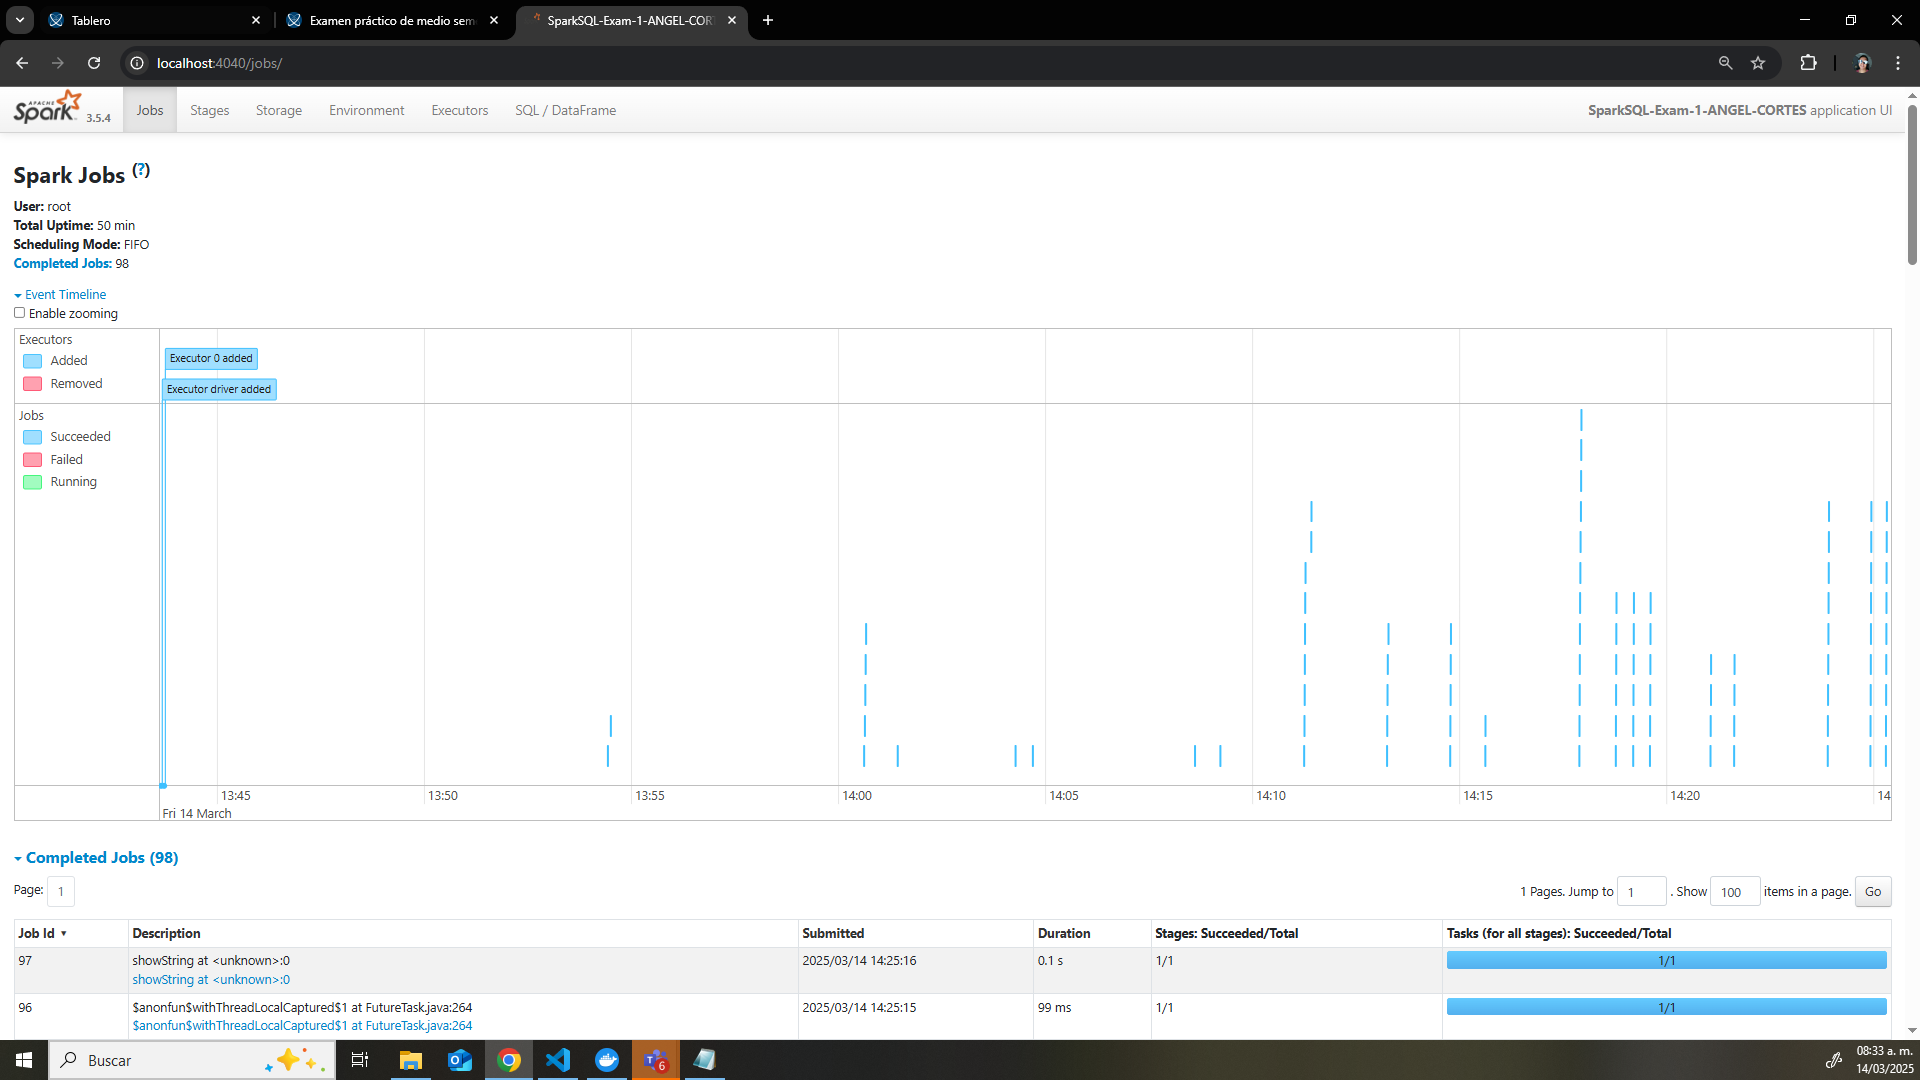

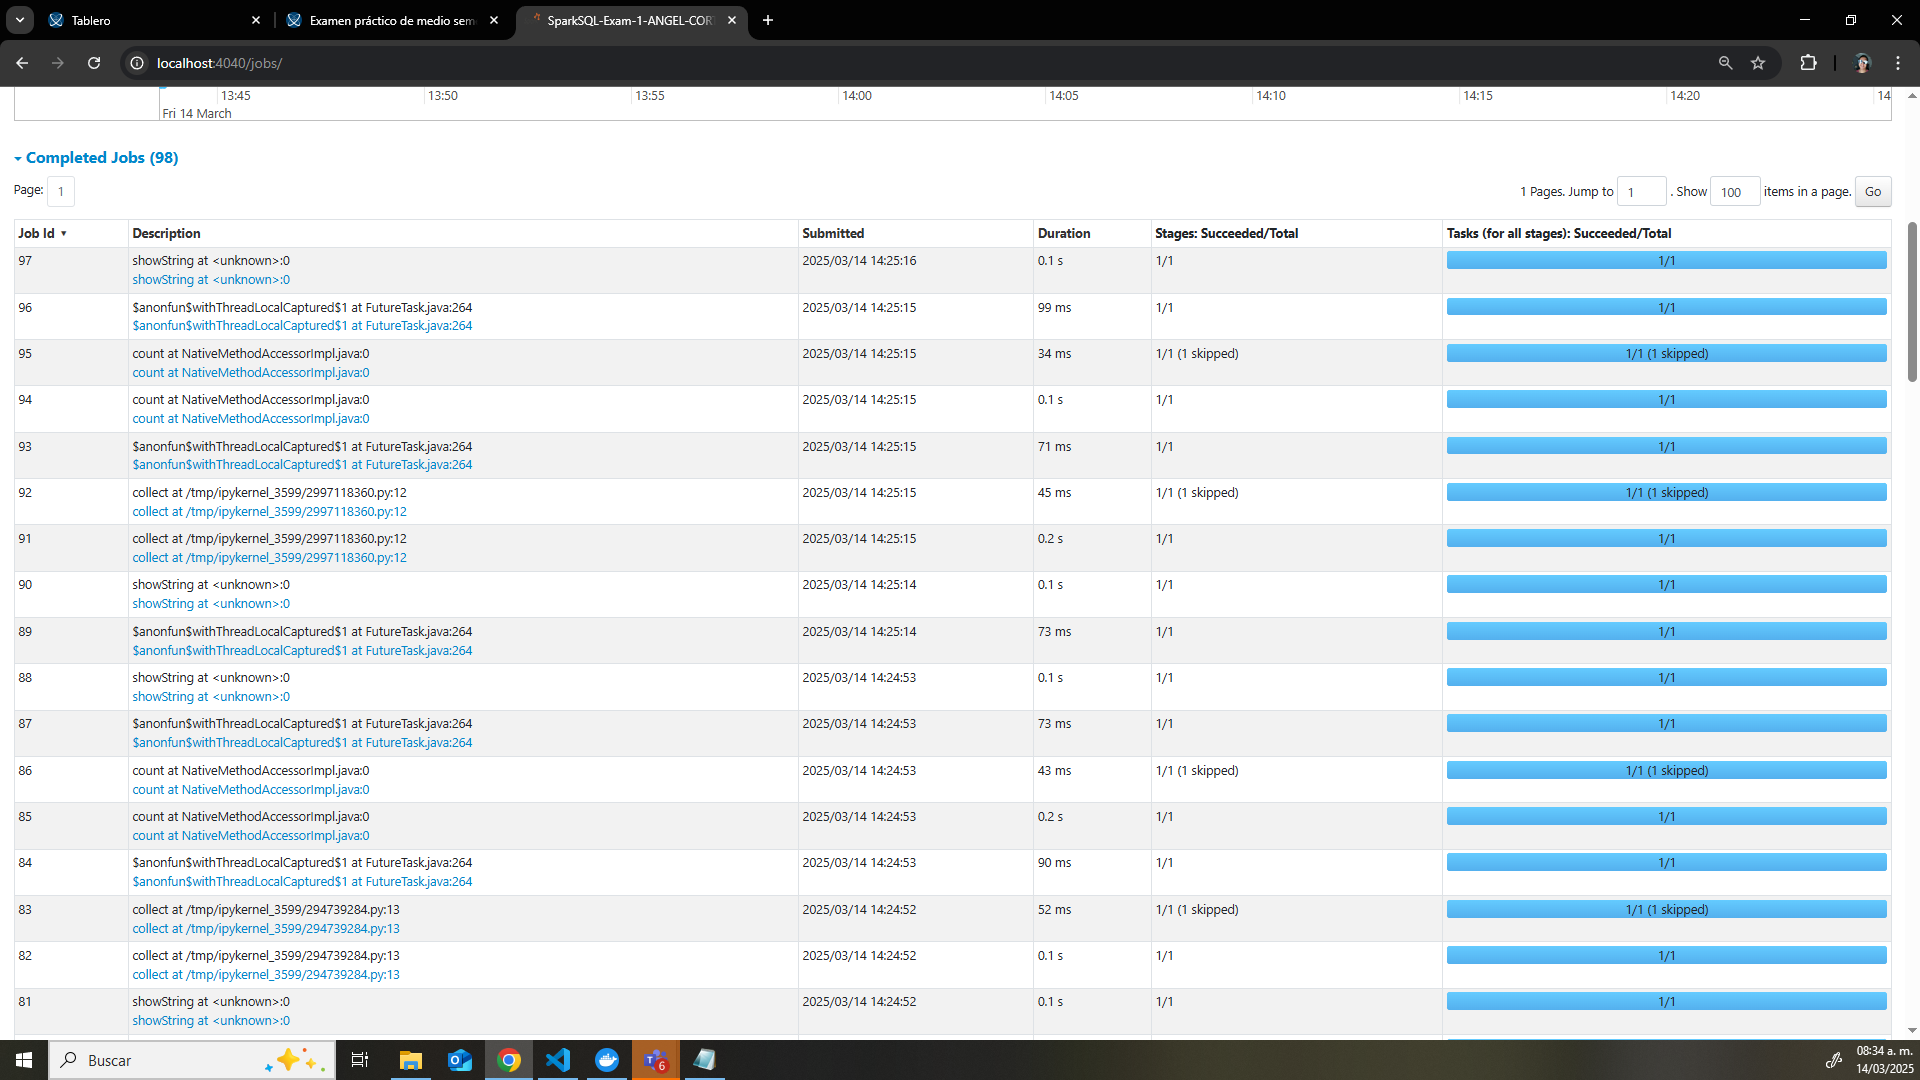

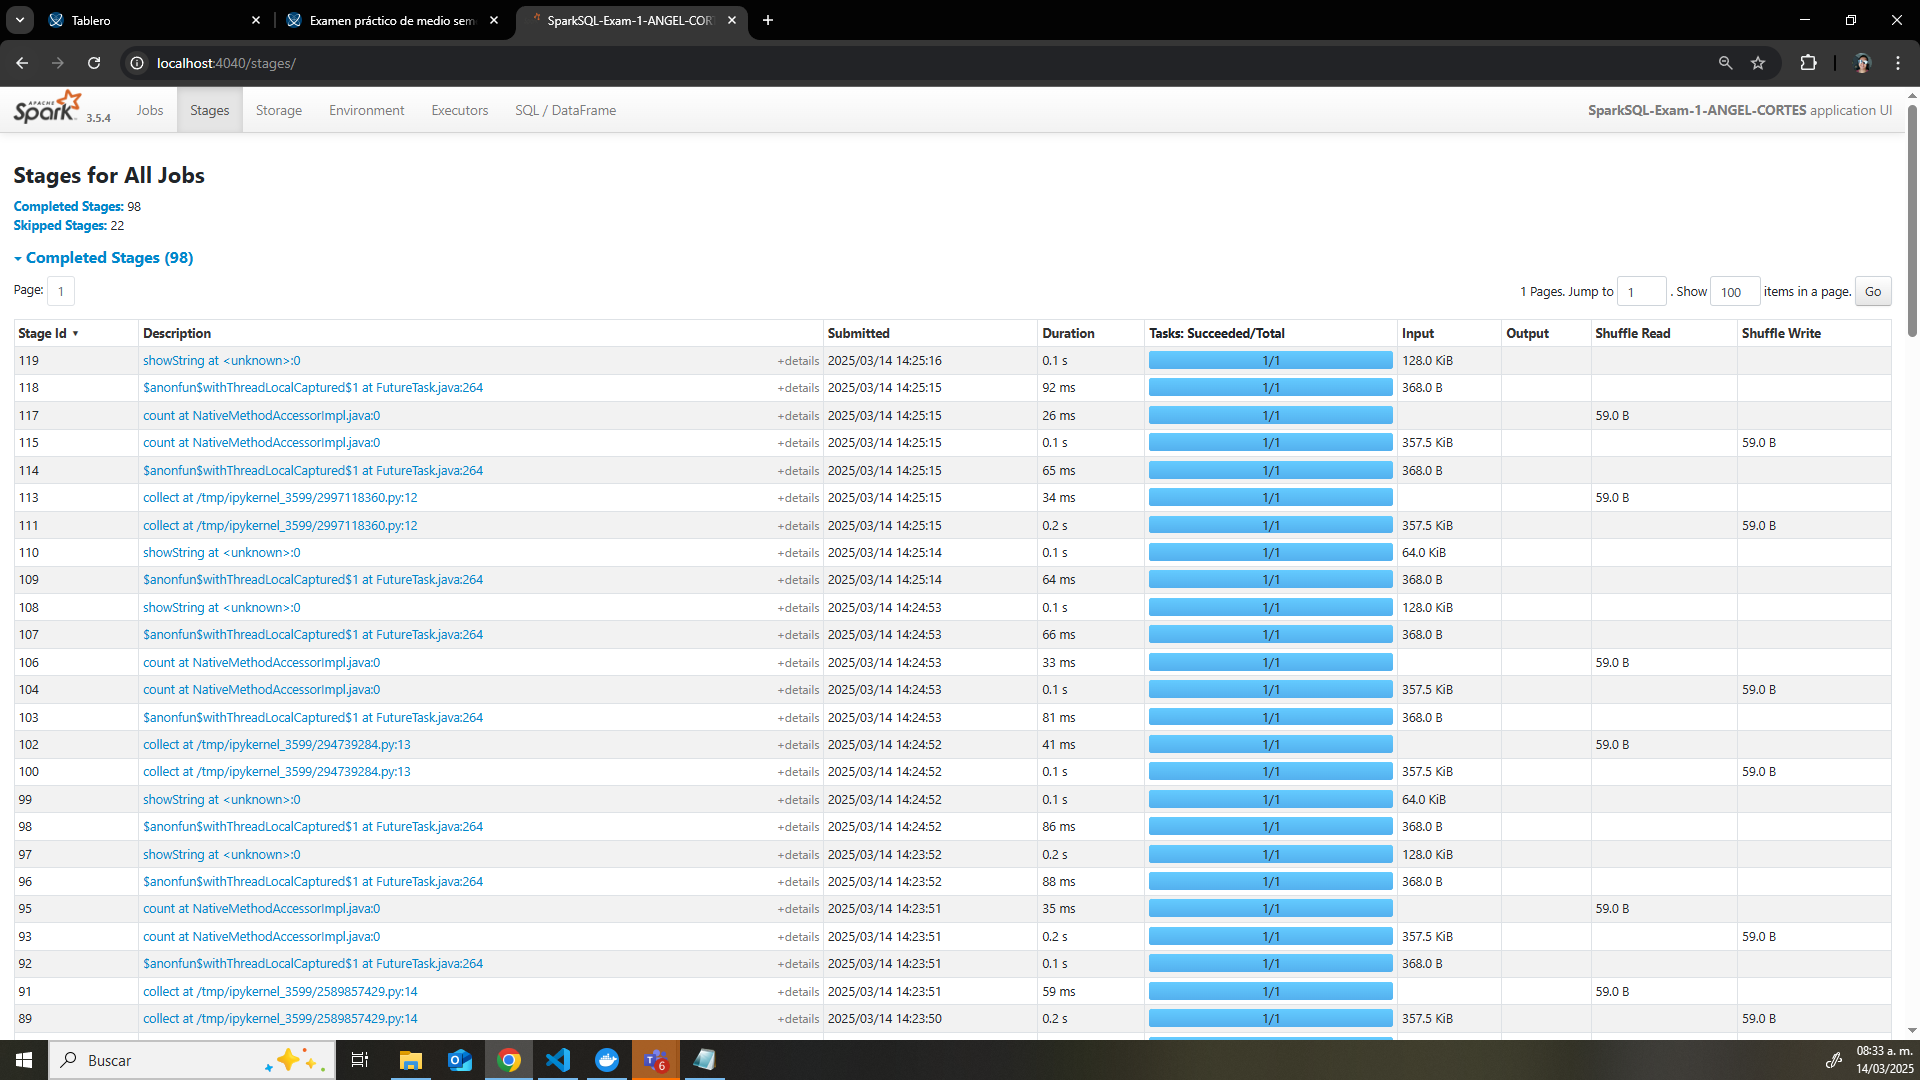



In [26]:
# Stop the SparkContext
sc.stop()